# DIALOGPT
### 220220018 천호진

## Introduction
DIALOGPT는 주어진 prompt에 맞는 conversational response를 생성하는 모델이다. GPT-2와 동일한 아키텍처를 사용하며 레딧 데이터를 사용해 학습되었다. <br>
2018년 OpenAI의 GPT-2는 매우 큰 데이터셋으로 학습된 트랜스포머 모델이 long-term dependencies를 잘 학습하고 유창하고 다양한 내용의 텍스트를 생성할 수 있다는 것을 보였다. DIALOGPT는 conversational neural response generation을 다루기 위해 GPT-2를 확장하였다. Conversational neural response generation은 신경망을 사용해 자연스러운 대화처럼 보이는 텍스트를 생성하는 작업이다. <br>
DIALOGPT는 GPT-2와 동일한 구조의 트랜스포머 아키텍처를 사용하는 AR 모델이다. GPT-2와의 차이점은 DIALOGPT는 reddit discussion chains에서 추출한 large-scale dialogue pairs를 사용해 학습되었다는 점이다. 이렇게 함으로써 DIALOGPT가 대화에서의 Source와 Target의 joint distribution (P(T,S))를 학습할 수 있다는 것이 아이디어이다.

## Dataset
데이터셋은 2005년부터 2017년까지 레딧에서 스크랩된 coment chains가 사용되었다. 레딧 discussion은 자연스럽게 tree 구조의 댓글 체인으로 확장될 수 있다. (하나의 thread가 다른 thread의 응답인 경우 하위 thread들의 루트 노드가 되는) 저자는 루트 노드에서 리프 노트까지의 각각의 path를 학습 인스턴스로 사용하였다. <br>

### Filtering
저자는 8개의 기준을 사용하여 데이터를 필터링하였다.
- Target/Source중 하나가 URL을 포함하는 경우
- Target에서 단어가 3번 이상 반복되는 경우
- 응답이 상위 50개의 자주 사용되는 단어를 하나도 포함하지 않을 경우("the", "of", "a" 등의 단어가 사용되지 않으면 영어가 아닐 가능성이 있음)
- 응답이 대괄호와 같은 마커를 포함하는 경우
- Source, Target 시퀀스를 합쳐 200 단어가 넘어가는 경우
- Target이 공격적인 언어를 포함하는 경우 (대용량 blocklist에서 찾아 필터링함)
- 많은 수의 subreddit이 공격적인 내용을 포함하는 경우
- response의 90%가 1000번 이상 포착된 tri-gram일 경우

## GPT-2
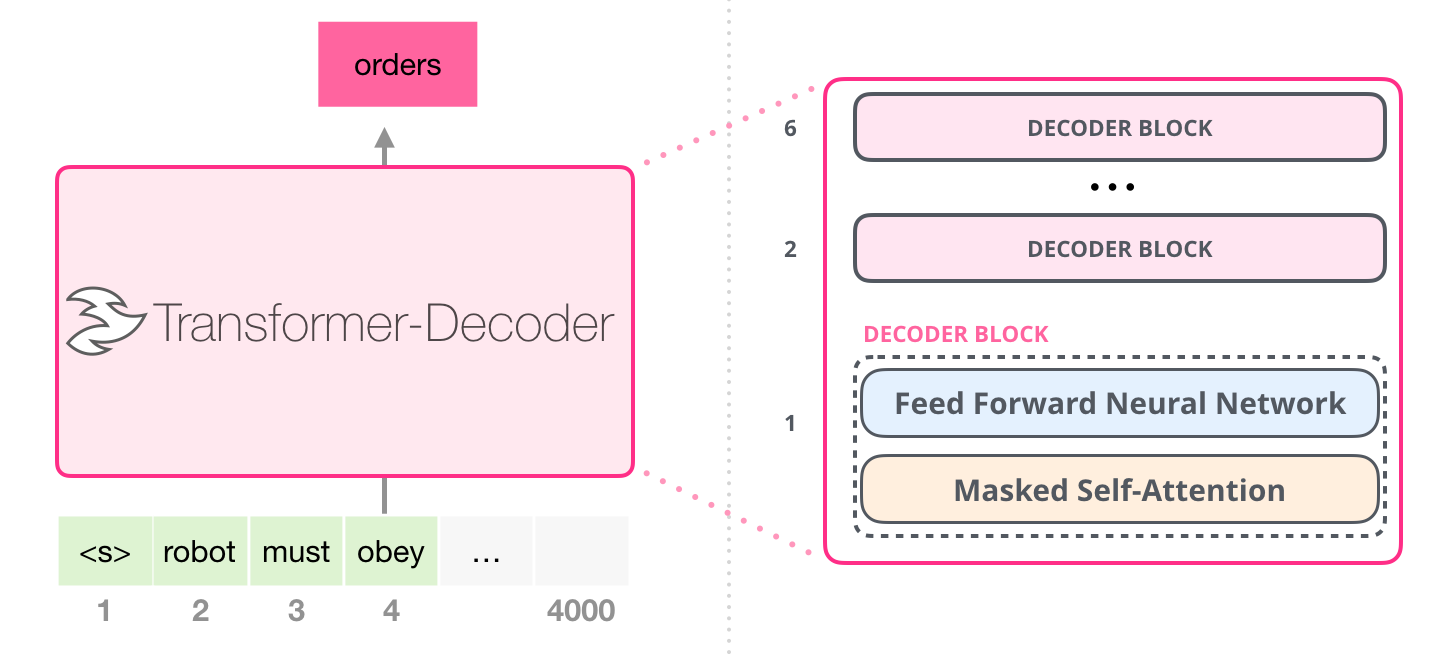
GPT-2는 현재와 이전 토큰만을 사용하여 다음 토큰을 예측하는 autoregressive language model이다. 트랜스포머의 디코더 블록만을 여러 층 쌓은 Transformer-Decoder를 사용한다. 디코더 블록의 masked multi-head attention이 현재와 이전 토큰에 대해서만 attention을 수행하기 때문이다. 인코더는 사용되지 않으므로 기존 트랜스포머의 디코더 블록에서 인코더-디코더 attention 레이어는 제거한다. <br>
GPT-2는 아래 방법(AR)으로 symbol $s$의 시퀀스를 사용해 example $x$의 분포를 추정한다. <br><br>
$p(x)=\prod_{i=1}^n{p(s_n|s_1,...,s_{n-1})}$

## DIALOGPT
DIALOGPT는 GPT-2와 동일한 모델 구조를 사용하고, source(dialogue history)가 주어졌을 때 target(response)를 예측하도록 학습된다. 전체 텍스트가 $x_1,...,x_N$이면 source는 $S=x_1,...,x_m$이고 target은 $T=x_{m+1},...,x_N$이다. DIALOGPT는 $P(T|S)=\prod_{n=m+1}^Np(x_n|x_1,..,x_n-1)$을 최대화하도록 학습된다.

### Mutual Information Maximization
$P(T|S)$처럼 source를 통해 target을 예측하기만 하는 likelihood를 최대화하는 방법이 어정쩡한 응답을 생성하게 하는 것 같다고 저자들은 추측했다. 저자는 미리 가능한 응답을 top-K 샘플링하여 hypothesis를 구성한 후, target을 통해 source를 예측하는 모델을 사용해 $P(S|T)$가 높은 순으로 hypothesis를 정렬하여 mutual information을 최대화함으로써 어정쩡한 응답이 생성되지 않게 하려고 시도했다.<br>
실험 결과 MMI-reranking 기법이 더 다양한 응답을 생성한다는 것을 알 수 있었다.

## 모델 구현

In [ ]:
'''인코더-디코더 attention이 제거된 트랜스포머의 디코더 블록을 구현한다.'''

def gelu(x):
    return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

class LayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-12):
        """Construct a layernorm module in the TF style (epsilon inside the square root).
        """
        super(LayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.bias = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = eps

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.weight * x + self.bias

class Conv1D(nn.Module):
    def __init__(self, nf, nx):
        super(Conv1D, self).__init__()
        self.nf = nf
        w = torch.empty(nx, nf)
        nn.init.normal_(w, std=0.02)
        self.weight = Parameter(w)
        self.bias = Parameter(torch.zeros(nf))

    def forward(self, x):
        size_out = x.size()[:-1] + (self.nf,)
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
        x = x.view(*size_out)
        return x
'''multi-head masked self-attention 구현'''
class Attention(nn.Module):
    def __init__(self, nx, n_ctx, config, scale=False):
        super(Attention, self).__init__()
        n_state = nx  # in Attention: n_state=768 (nx=n_embd)
        # [switch nx => n_state from Block to Attention to keep identical to TF implem]
        assert n_state % config.n_head == 0
        self.register_buffer("bias", torch.tril(torch.ones(n_ctx, n_ctx)).view(1, 1, n_ctx, n_ctx))
        self.n_head = config.n_head
        self.split_size = n_state
        self.scale = scale
        self.c_attn = Conv1D(n_state * 3, nx)
        self.c_proj = Conv1D(n_state, nx)

    def _attn(self, q, k, v):
        w = torch.matmul(q, k)
        if self.scale:
            w = w / math.sqrt(v.size(-1))
        nd, ns = w.size(-2), w.size(-1)
        b = self.bias[:, :, ns-nd:ns, :ns]
        w = w * b - 1e10 * (1 - b)
        w = nn.Softmax(dim=-1)(w)
        return torch.matmul(w, v)

    def merge_heads(self, x):
        x = x.permute(0, 2, 1, 3).contiguous()
        new_x_shape = x.size()[:-2] + (x.size(-2) * x.size(-1),)
        return x.view(*new_x_shape)  # in Tensorflow implem: fct merge_states

    def split_heads(self, x, k=False):
        new_x_shape = x.size()[:-1] + (self.n_head, x.size(-1) // self.n_head)
        x = x.view(*new_x_shape)  # in Tensorflow implem: fct split_states
        if k:
            return x.permute(0, 2, 3, 1)  # (batch, head, head_features, seq_length)
        else:
            return x.permute(0, 2, 1, 3)  # (batch, head, seq_length, head_features)

    def forward(self, x, layer_past=None):
        x = self.c_attn(x)
        query, key, value = x.split(self.split_size, dim=2)
        query = self.split_heads(query)
        key = self.split_heads(key, k=True)
        value = self.split_heads(value)
        if layer_past is not None:
            past_key, past_value = layer_past[0].transpose(-2, -1), layer_past[1]  # transpose back cf below
            key = torch.cat((past_key, key), dim=-1)
            value = torch.cat((past_value, value), dim=-2)
        present = torch.stack((key.transpose(-2, -1), value))  # transpose to have same shapes for stacking
        a = self._attn(query, key, value)
        a = self.merge_heads(a)
        a = self.c_proj(a)
        return a, present

class MLP(nn.Module):
    def __init__(self, n_state, config):  # in MLP: n_state=3072 (4 * n_embd)
        super(MLP, self).__init__()
        nx = config.n_embd
        self.c_fc = Conv1D(n_state, nx)
        self.c_proj = Conv1D(nx, n_state)
        self.act = gelu

    def forward(self, x):
        h = self.act(self.c_fc(x))
        h2 = self.c_proj(h)
        return h2

'''디코더 블록 구현'''
class Block(nn.Module):
    def __init__(self, n_ctx, config, scale=False):
        super(Block, self).__init__()
        nx = config.n_embd
        self.ln_1 = LayerNorm(nx, eps=config.layer_norm_epsilon)
        self.attn = Attention(nx, n_ctx, config, scale)
        self.ln_2 = LayerNorm(nx, eps=config.layer_norm_epsilon)
        self.mlp = MLP(4 * nx, config)

    def forward(self, x, layer_past=None):
        '''layer normalize, self-attention, layer normalize, MLP 순서로 포워드'''
        a, present = self.attn(self.ln_1(x), layer_past=layer_past)
        x = x + a
        m = self.mlp(self.ln_2(x))
        x = x + m
        return x, present


In [ ]:
'''GPT2Model : 디코더 블록 스택에 해당함'''
class GPT2Model(nn.Module):
    def __init__(self, config):
        super(GPT2Model, self).__init__()
        self.n_layer = config.n_layer
        self.n_embd = config.n_embd
        self.n_vocab = config.vocab_size

        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        self.wpe = nn.Embedding(config.n_positions, config.n_embd)
        block = Block(config.n_ctx, config, scale=True)
        self.h = nn.ModuleList([copy.deepcopy(block) for _ in range(config.n_layer)])
        self.ln_f = LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
    ''''''
    def set_embeddings_weights(self, model_embeddings_weights):
        embed_shape = model_embeddings_weights.shape
        self.decoder = nn.Linear(embed_shape[1], embed_shape[0], bias=False)
        self.decoder.weight = model_embeddings_weights  # Tied weights

    def forward(self, input_ids, position_ids=None, token_type_ids=None, past=None):
        if past is None:
            past_length = 0
            past = [None] * len(self.h)
        else:
            past_length = past[0][0].size(-2)
        if position_ids is None:
            position_ids = torch.arange(past_length, input_ids.size(-1) + past_length, dtype=torch.long,
                                        device=input_ids.device)
            position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        input_shape = input_ids.size()
        input_ids = input_ids.view(-1, input_ids.size(-1))
        position_ids = position_ids.view(-1, position_ids.size(-1))
        
        inputs_embeds = self.wte(input_ids)
        position_embeds = self.wpe(position_ids)
        if token_type_ids is not None:
            token_type_ids = token_type_ids.view(-1, token_type_ids.size(-1))
            token_type_embeds = self.wte(token_type_ids)
        else:
            token_type_embeds = 0
        '''워드임베딩, 포지셔널 임베딩 계산 후에 더하여 hidden_states 생성'''
        hidden_states = inputs_embeds + position_embeds + token_type_embeds
        presents = []
        '''앞에서 구현한 디코더 블록에 hidden_states 입력'''
        for block, layer_past in zip(self.h, past):
            hidden_states, present = block(hidden_states, layer_past)
            presents.append(present)
        hidden_states = self.ln_f(hidden_states)
        output_shape = input_shape + (hidden_states.size(-1),)
        '''디코더 블록의 출력을 반환'''
        return hidden_states.view(*output_shape), presents

'''GPT2LMHead : 디코더 블록의 출력을 입력해 linear 레이어로 logit을 계산함 (디코더 출력으로 토큰 예측)'''
class GPT2LMHead(nn.Module):
    def __init__(self, model_embeddings_weights, config):
        super(GPT2LMHead, self).__init__()
        self.n_embd = config.n_embd
        self.set_embeddings_weights(model_embeddings_weights)

    def set_embeddings_weights(self, model_embeddings_weights):
        embed_shape = model_embeddings_weights.shape
        self.decoder = nn.Linear(embed_shape[1], embed_shape[0], bias=False)
        self.decoder.weight = model_embeddings_weights  # Tied weights

    def forward(self, hidden_state):
        # Truncated Language modeling logits (we remove the last token)
        # h_trunc = h[:, :-1].contiguous().view(-1, self.n_embd)
        lm_logits = self.decoder(hidden_state)
        return lm_logits

class GPT2LMHeadModel(nn.Module):
    def __init__(self, config):
        super(GPT2LMHeadModel, self).__init__()
        self.transformer = GPT2Model(config)
        self.lm_head = GPT2LMHead(self.transformer.wte.weight, config)

    def set_tied(self):
        """ Make sure we are sharing the embeddings
        """
        self.lm_head.set_embeddings_weights(self.transformer.wte.weight)

    def forward(self, input_ids, position_ids=None, token_type_ids=None, lm_labels=None, past=None):
        '''트랜스포머(GPT2Model)에 시퀀스 입력 후 출력 hidden_states를 얻고
           hidden_states로부터 다음 토큰의 분포(lm_logits) 계산'''
        hidden_states, presents = self.transformer(input_ids, position_ids, token_type_ids, past)
        lm_logits = self.lm_head(hidden_states)
        '''cross entropy loss 계산 후 loss 반환'''
        if lm_labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-1)
            loss = loss_fct(lm_logits.view(-1, lm_logits.size(-1)), lm_labels.view(-1))
            return loss
        return lm_logits, presents

## 모델 학습

In [ ]:
while True:
    model.train()
    (tr_loss, tr_ppl, mean_ppl, nb_tr_examples, nb_tr_steps) = 0.0, 0.0, 0.0, 0, 0
    n_token_real, n_token_total = 0, 0
    train_start_time_epoch = time.time()
    for batch in train_dataloader:
        # activate new training mode
        seq_len = batch[0].shape[1]
        batch = tuple(t.to(device) for t in batch)
        input_ids, position_ids, token_ids, label_ids, *_ = batch
        if args.no_token_id:
            token_ids = None
        '''모델에 데이터 입력하여 loss 계산'''
        loss, ppl = model(input_ids, position_ids, token_ids, label_ids)

        if n_gpu > 1:
            loss = loss.mean()
            ppl = ppl.mean()
        loss = loss / (args.train_batch_size / input_ids.shape[0])
        if args.fp16:
            optimizer.backward(loss)
        else:
            loss.backward()

        tr_loss += float(loss.item()) * (args.train_batch_size / input_ids.shape[0])
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
        mean_loss = tr_loss / nb_tr_steps
        if ppl.item() < INF:
            tr_ppl += ppl.item()
        else:
            tr_ppl += mean_ppl
        mean_ppl = tr_ppl / nb_tr_steps

        n_token_total += input_ids.shape[0] * input_ids.shape[1]
        n_token_real += (input_ids != 0).sum().item()
        '''오차 역전파'''
        # gradient update
        step += 1
        if step % args.gradient_accumulation_steps == 0:
            set_lr(optimizer, global_step,
                   args.lr_schedule, args.learning_rate,
                   args.warmup_steps, args.warmup_proportion,
                   config.n_embd, args.num_optim_steps)

            if args.local_rank != -1:
                grads = [p.grad.data for p in model.parameters()
                         if p.requires_grad and p.grad is not None]
                all_reduce_and_rescale_tensors(grads, float(1))

            optimizer.step()
            optimizer.zero_grad()
            global_step += 1

## MMI Decoder 구현
아래 코드는 Source와 Target 사이의 mutual information maximization을 통해 더 자연스럽고 다양한 응답을 생성하는 디코더의 구현이다.

In [ ]:
torch.set_grad_enabled(False)

tokenizer = GPT2Tokenizer('medium/vocab.json', 'medium/merges.txt')

weights = torch.load('medium/medium_ft.pkl')
# fix misused key value
weights["lm_head.weight"] = weights["lm_head.decoder.weight"]
weights.pop("lm_head.decoder.weight", None)

cfg = GPT2Config.from_json_file('medium/config.json')
'''응답 생성 모델을 불러온다. (P(T|S)를 maximize한 모델)'''
model: GPT2LMHeadModel = GPT2LMHeadModel(cfg)
model.load_state_dict(weights)
if device_f == 'cuda':
    model.half()
model.to(device_f)
model.eval()

weights = torch.load('medium/small_reverse.pkl')
# fix misused key value
weights["lm_head.weight"] = weights["lm_head.decoder.weight"]
weights.pop("lm_head.decoder.weight", None)
'''Reverse model을 선언하고 불러온다. (P(S|T)를 maximize한 모델)'''
reverse_model: GPT2LMHeadModel = GPT2LMHeadModel(cfg)
reverse_model.load_state_dict(weights)
if device_r == 'cuda':
    reverse_model.half()
reverse_model.to(device_r)
reverse_model.eval()


end_token = torch.tensor([[50256]], dtype=torch.long)

'''Top-K 샘플링을 사용하여 응답을 생성하는 함수'''
def _get_response(output_token, past):
    out = torch.tensor([[]], dtype=torch.long, device=device_f)

    while True:
        output_token, past = model.forward(output_token, past=past)
        output_token = output_token[:, -1, :].float()
        indices_to_remove = output_token < torch.topk(output_token, top_k)[0][..., -1, None]
        output_token[indices_to_remove] = -float('Inf')
        output_token = torch.multinomial(F.softmax(output_token, dim=-1), num_samples=1)

        out = torch.cat((out, output_token), dim=1)

        if output_token.item() == end_token.item():
            break

    return out, past

'''생성한 응답을 reverse_model을 사용하여 평가하는 함수'''
def _score_response(output_token, correct_token):
    inputs = torch.cat((output_token, correct_token), dim=1)
    mask = torch.full_like(output_token, -100, dtype=torch.long)
    labels = torch.cat((mask, correct_token), dim=1)

    loss, _, _ = reverse_model(inputs, labels=labels)

    return -loss.float()


def append_messages(old_list: list, new_list: list, truncate_length=64):
    for message in new_list:
        if message != '':
            input_token = tokenizer.encode(message, return_tensors='pt')
            input_token = torch.cat((input_token, end_token), dim=1)
            old_list.append(input_token)

    if len(old_list) == 0:
        old_list.append(end_token)

    # truncate
    total_length = 0
    for i, message in enumerate(reversed(old_list)):
        total_length += message.shape[1]
        if total_length > truncate_length:
            old_list[:] = old_list[-i:]


def generate_message(message_list: list, focus_last_message=True):
    total_input = torch.cat(message_list, dim=1).to(device_f)
    if focus_last_message:
        total_input_reversed = message_list[-1]
    else:
        total_input_reversed = torch.cat(list(reversed(message_list)), dim=1)

    past = None
    if total_input.shape[1] > 1:
        _, past = model(total_input[:, :-1])

    results = []
    for i in range(num_samples):
        '''입력을 넣어 _get_response() 함수로 top-k 샘플링을 사용한 응답을 생성하고
           _score_response() 함수를 사용해 응답을 평가한다. (MMI)'''
        result = _get_response(total_input[:, -1:], past)
        score = _score_response(result[0].to(device_r), total_input_reversed.to(device_r))
        results.append(result + (score,))

    scores = torch.stack([x[2] for x in results], dim=0)
    '''최종적으로 softmax에 temperature scaling을 적용하여 토큰을 선택한다.'''
    winner = torch.multinomial(F.softmax(scores / MMI_temperature, dim=0), num_samples=1).item()
    # winner = torch.argmax(scores, dim=0)

    out = results[winner][0]
    '''토큰 인덱스의 시퀀스를 문자열의 시퀀스로 변환해 반환한다.'''
    return tokenizer.decode(out.tolist()[0], skip_special_tokens=True)


if __name__ == '__main__':
    my_message_list = []
    while True:
        my_message = input('usr >> ')
        append_messages(my_message_list, [my_message])
        my_response = generate_message(my_message_list)
        print('bot >>', my_response)
        append_messages(my_message_list, [my_response])

## 텍스트 생성
제공되는 pretrained m,odel을 사용하여 text generation을 할 수 있다.

In [34]:
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
model = AutoModelWithLMHead.from_pretrained("microsoft/DialoGPT-small")

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/641 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/auto/modeling_auto.py:1177: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


Downloading:   0%|          | 0.00/351M [00:00<?, ?B/s]

In [35]:
# Let's chat for 5 lines
for step in range(5):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')

    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # generated a response while limiting the total chat history to 1000 tokens    
    chat_history_ids = model.generate(
    bot_input_ids, max_length=1000,
    pad_token_id=tokenizer.eos_token_id
    )

    # pretty print last ouput tokens from bot
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

>> User:hi


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: Hi
>> User:The weather is cold


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: I'm a girl
>> User:so what


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: I'm a girl
>> User:so what???


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: I'm a girl
>> User:ok


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


DialoGPT: I'm a girl
